# Back Propagation

## Import Library

In [27]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import OrderedDict
import copy
# from PIL import Image
# import pickle
import import_ipynb
sys.path.append(os.pardir)
from DataSet.mnist import load_mnist
from Ch2_3.handWrittenDigit import get_data, init_network, predict, img_show
from Ch2_3.activation_function import softmax, sigmoid
from Ch4.load_error import cross_entropy_error
from Ch4.gradient import numerical_gradient

## Multiply Layer

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self,x,y):
        self.x = x
        self.y = y
        out = x*y
        
        return out
    
    def backward(self,dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [3]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple,apple_num)
price = mul_tax_layer.forward(apple_price,tax)

print(price)

220.00000000000003


In [4]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


## Add Layer

In [5]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self,x,y):
        out = x+y
        return out
    
    def backward(self,dout):
        dx = dout*1
        dy = dout*1
        return dx, dy


In [6]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# Layers
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# Forward Propagation
apple_price = mul_apple_layer.forward(apple,apple_num)
orange_price = mul_orange_layer.forward(orange,orange_num)
all_price = add_apple_orange_layer.forward(apple_price,orange_price)
price = mul_tax_layer.forward(all_price,tax)

# Backward Propagation
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(price)
print(dapple_num,dapple,dorange,dorange_num,dtax)


715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## ReLu Layer

In [7]:
class ReLu:
    def __init__(self):
        self.mask = None
        
    def forward(self,x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

## Sigmoid Layer

In [8]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

## Affine Layer

In [9]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0],-1)
        self.x = x
        
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self,dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)
        return dx

In [10]:
affine = Affine(np.array([[1,1,1],[1,1,1]]),np.array([1,2,3]))
# np.dot(np.array([[0,0],[0,10]]),affine.W)
print(affine.forward(np.array([[0,0],[0,10]])))
print(affine.backward(np.array([[4,5,6],[7,8,9]])))

[[ 1  2  3]
 [11 12 13]]
[[15 15]
 [24 24]]


## Softmax with Loss Layer

In [11]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
            
        return dx

# 오차역전파를 이용한 신경만 구현

In [12]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,\
                    weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
                Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLu()
        self.layers['Affine2'] = \
                Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads
        

## 기울기 확인 ( Gradient Check )

In [91]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
    
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop  = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ':' + str(diff))

W1:2.384085750233105e-13
b1:8.718057124736805e-13
W2:9.105375845669394e-13
b2:1.201261257133268e-10


In [92]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True,one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# hyper parameter
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 100
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # step 1 : Mini Batch training
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # step 2 : Gradient
    # grad = network.numerical_gradient(x_batch,t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # step 3 : update parameter
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate*grad[key]
        
    # step 4 : record history & back to step 1
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc)+\
            ', '+str(test_acc))

train acc, test acc | 0.16396666666666668, 0.168
train acc, test acc | 0.9037, 0.9072
train acc, test acc | 0.92265, 0.9221
train acc, test acc | 0.9351833333333334, 0.9338
train acc, test acc | 0.9434833333333333, 0.941
train acc, test acc | 0.9474166666666667, 0.9461
train acc, test acc | 0.9541333333333334, 0.952
train acc, test acc | 0.95805, 0.9536
train acc, test acc | 0.9617833333333333, 0.9562
train acc, test acc | 0.96385, 0.9578
train acc, test acc | 0.9676833333333333, 0.9619
train acc, test acc | 0.9690166666666666, 0.9631
train acc, test acc | 0.9694666666666667, 0.964
train acc, test acc | 0.9725666666666667, 0.9674
train acc, test acc | 0.9750666666666666, 0.9672
train acc, test acc | 0.9756, 0.9681
train acc, test acc | 0.9768, 0.9676


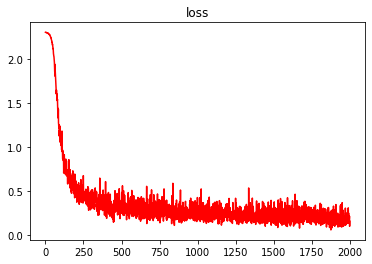

In [93]:
plt.title('loss')
plt.plot(train_loss_list[:2000],'-r')
plt.show()

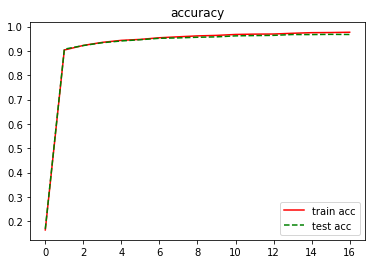

In [94]:
plt.title('accuracy')
plt.plot(train_acc_list,'-r',label = 'train acc')
plt.plot(test_acc_list,'--g',label = 'test acc')
plt.legend()
plt.show()

## k-fold

In [95]:
def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.
    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

In [98]:
x_train, t_train = shuffle_dataset(x_train,t_train)
x_total = x_train.copy()
t_total = t_train.copy()

x_train_dic = {}
x_test_dic = {}
t_train_dic = {}
t_test_dic = {}

fold_str = ['0','1','2','3','4']
fold_size = 10000
for fold_key in fold_str:
    for i in range(5):
        x_test_dic[fold_key] = x_total[i*fold_size:(i+1)*fold_size]
        t_test_dic[fold_key] = t_total[i*fold_size:(i+1)*fold_size]
        x_train_dic[fold_key] = np.concatenate((x_total[:i*fold_size],x_total[(i+1)*fold_size:]),axis=0)
        t_train_dic[fold_key] = np.concatenate((t_total[:i*fold_size],t_total[(i+1)*fold_size:]),axis=0)

In [99]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

# hyper parameter
# 25 epochs
iters_num = 10000
# train_size = x_train.shape[0]
train_size = 40000
batch_size = 100
learning_rate = 0.1
networks={}
for fold_key in x_train_dic.keys():
    networks[fold_key] = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 400 per epoch
iter_per_epoch = max(train_size / batch_size, 1)


batch_offset = 0
fold_offset = 0
for fold_key in x_train_dic.keys():
    print('==========='+fold_key+' epoch'+'=============')
    for i in range(iters_num):
        # step 1 : Mini Batch training
        batch_mask = np.random.choice(train_size,batch_size)
        # x_batch = x_train[batch_mask]
        # t_batch = t_train[batch_mask]
        x_batch = x_train_dic[fold_key][batch_mask]
        t_batch = t_train_dic[fold_key][batch_mask]
        
        
        # step 2 : Gradient
        # grad = network.numerical_gradient(x_batch,t_batch)
        grad = networks[fold_key].gradient(x_batch, t_batch)
        
        # step 3 : update parameter
        for key in ('W1','b1','W2','b2'):
            networks[fold_key].params[key] -= learning_rate*grad[key]
            
        # step 4 : record history & back to step 1
        loss = networks[fold_key].loss(x_batch,t_batch)
        train_loss_list.append(loss)
        
        batch_offset = batch_offset + batch_size
        if i % iter_per_epoch == 0:
            train_acc = networks[fold_key].accuracy(x_train_dic[fold_key],t_train_dic[fold_key])
            test_acc = networks[fold_key].accuracy(x_test_dic[fold_key],t_test_dic[fold_key])
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print("train acc, test acc | " + str(train_acc)+\
                ', '+str(test_acc))

===========0 epoch=============
train acc, test acc | 0.11494, 0.1091
train acc, test acc | 0.88614, 0.8888
train acc, test acc | 0.9093, 0.9111
train acc, test acc | 0.92228, 0.9217
train acc, test acc | 0.92972, 0.9275
train acc, test acc | 0.93384, 0.9321
train acc, test acc | 0.93958, 0.9367
train acc, test acc | 0.94808, 0.9438
train acc, test acc | 0.94964, 0.9451
train acc, test acc | 0.95594, 0.9477
train acc, test acc | 0.95954, 0.9511
train acc, test acc | 0.96086, 0.953
train acc, test acc | 0.9633, 0.955
train acc, test acc | 0.96592, 0.9563
train acc, test acc | 0.96816, 0.9587
train acc, test acc | 0.9691, 0.9597
train acc, test acc | 0.97154, 0.9602
train acc, test acc | 0.97246, 0.9621
train acc, test acc | 0.97198, 0.9631
train acc, test acc | 0.9756, 0.9633
train acc, test acc | 0.97224, 0.9602
train acc, test acc | 0.97766, 0.9633
train acc, test acc | 0.97876, 0.9642
train acc, test acc | 0.97678, 0.9639
train acc, test acc | 0.97948, 0.9657
===========1 epoch======

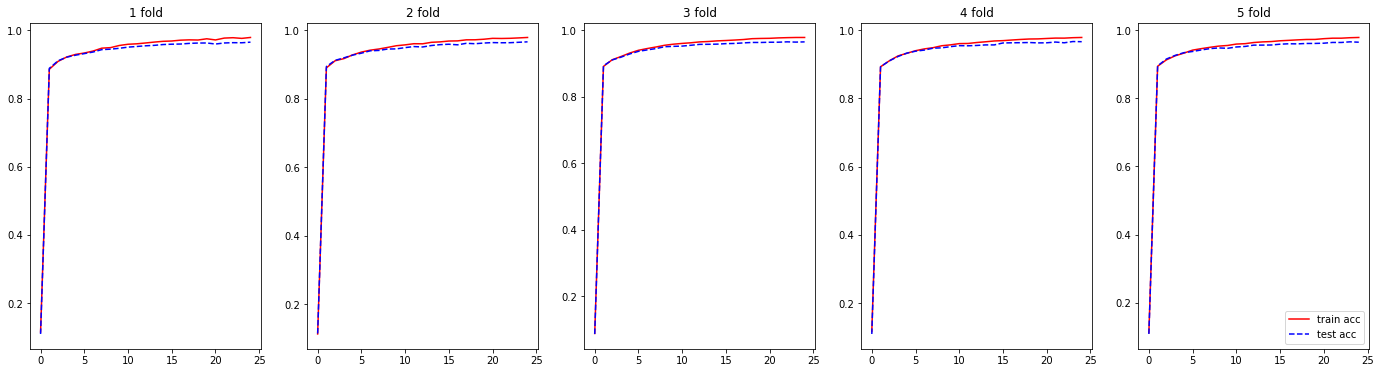

In [100]:
plt.figure(figsize=(24,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(str(i+1)+' fold')
    plot_range = i*25
    plt.plot(train_acc_list[plot_range:plot_range+25],'-r',label='train acc')
    plt.plot(test_acc_list[plot_range:plot_range+25],'--b',label='test acc')
    
plt.legend()
plt.show()

In [101]:
final_train_acc = 0
final_test_acc = 0
for i in range(5):
    final_train_acc += train_acc_list[24+i*25]
    final_test_acc += test_acc_list[24+i*25]
    
final_train_acc /= 5
final_test_acc /= 5
print('final train accuracy : '+str(final_train_acc))
print('final test accuracy : '+str(final_test_acc))

final train accuracy : 0.9787320000000002
final test accuracy : 0.9654999999999999
